<h1> For Cantera <br>
<h5> This file takes up a scheme, and dynamically print out results for Input_Config.
<h5> Solves the 0D case for multiple cases.<br>
<h5> Print and plot the autoignition time for all of them.<br>

In [1]:
import sys
import numpy as np
import cantera as ct
import matplotlib.pyplot as plt
from matplotlib import *
import csv

In [2]:
scheme = 'BFER_methane'
gas = ct.Solution(scheme'.yaml', 'CH4_BFER_mix')
gas.TPX = 1000.0, ct.one_atm, {'CH4':1, 'O2':2, 'N2':7.52} 

density = gas.density
viscosity = gas.viscosity
thermal_conductivity = gas.thermal_conductivity
kinematic_viscosity = viscosity / density  # m²/s

species_names = gas.species_names
#molar_masses = gas.molecular_weights  # kg/kmol
diff_coeffs = gas.mix_diff_coeffs  # m²/s
mass_fractions = gas.Y

print(gas())    
print(f"Density: {density:.2e} kg/m³")
print(f"Kinematic Viscosity: {kinematic_viscosity:.2e} m²/s")
print(f"Thermal Conductivity: {thermal_conductivity:.2e} W/m/K\n\n")

for i, specie in enumerate(species_names):
    print(f"Species: {specie}")
    #print(f"Molar Mass: {molar_masses[i]:.2e} kg/kmol")
    print(f"Mass Fraction: {mass_fractions[i]:.2e}")
    print(f"Mix Diffusion Coefficient: {diff_coeffs[i]:.2e}")
    print("")


  CH4_BFER_mix:

       temperature   1000 K
          pressure   1.0132e+05 Pa
           density   0.33676 kg/m^3
  mean mol. weight   27.633 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        5.8795e+05        1.6247e+07  J
   internal energy        2.8706e+05        7.9325e+06  J
           entropy            8664.6        2.3943e+05  J/K
    Gibbs function       -8.0767e+06       -2.2319e+08  J
 heat capacity c_p            1340.7             37049  J/K
 heat capacity c_v            1039.8             28734  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                O2           0.22014           0.19011           -28.226
               CH4          0.055187          0.095057           -36.538
                N2           0.72467           0.71483          

In [3]:
# Initial temperatures
Temperature_range = list(range(800, 1700, 200))

# Specify the number of time steps and the time step size
nt = 100000
dt = 8.e-8  # s

# Storing auto ignitions
auto_ignitions = []

In [4]:
for index, Temperature in enumerate(Temperature_range):
    #################################################################
    # Initial temperature, Pressure and stoichiometry
    gas.TPX = Temperature, ct.one_atm, {'CH4':1, 'O2':2, 'N2':7.52} 
    # Create the batch reactor
    r = ct.IdealGasReactor(gas)
    # Now create a reactor network consisting of the single batch reactor
    sim = ct.ReactorNet([r])
    # Storage space
    mfrac = []
    # ...
    time = []
    temperature = []
    HR = []
    # Run the simulation
    # Initial simulation time
    current_time = 0.0
    # Loop for nt time steps of dt seconds.
    for n in range(nt):
        current_time += dt
        sim.advance(current_time)
        time.append(current_time)
        temperature.append(r.T)
        mfrac.append(r.thermo.Y)
        HR.append(- np.dot(gas.net_production_rates, gas.partial_molar_enthalpies)) #Calculates the heat release rate using the net production rates of species and their partial molar enthalpies.
    #################################################################
    # Catch the autoignition timing
    #################################################################
    # Get the ignition delay time by the maximum value of the Heat Release rate
    auto_ignition = time[HR.index(max(HR))] #Finds the ignition time (time of maximum heat release rate) by locating the index in the HR list where the maximum value occurs and then finding the corresponding time from the time list
    print('For T = ' + str(Temperature) + ', Autoignition time = ' + str(auto_ignition) + ' s')
    # Posterity
    FinalTemp = temperature[nt - 1]
    auto_ignitions.append(auto_ignition)
    # #################################################################
    # # Save results
    # #################################################################
    # # write output CSV file for importing into Excel
    # csv_file = '3-Output/Phi-1_P-1_T-' + str(Temperature) + '_UV.csv'
    # with open(csv_file, 'w') as outfile:
    # writer = csv.writer(outfile)
    # writer.writerow(['Auto ignition time [s]', 'Final Temperature [K]'] + gas.species_names)
    # writer.writerow([auto_ignition, FinalTemp] + list(mfrac[:]))
    # print('output written to ' + csv_file)
T_invert = [1000 / Temperature for Temperature in Temperature_range]

For T = 800, Autoignition time = 0.008000000000016327 s
For T = 1000, Autoignition time = 0.0014802399999995438 s
For T = 1200, Autoignition time = 0.00012671999999999965 s
For T = 1400, Autoignition time = 2.399999999999985e-05 s
For T = 1600, Autoignition time = 7.280000000000006e-06 s


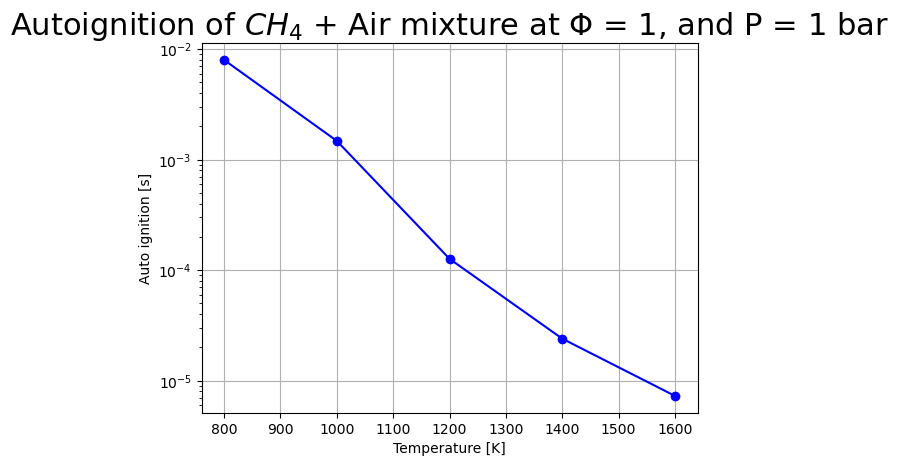

In [5]:
#################################################################
# Plot results
#################################################################
# create plot
plt.plot(Temperature_range, auto_ignitions, 'b-o')
plt.xlabel(r'Temperature [K]')
plt.ylabel("Auto ignition [s]")
plt.yscale('log')
plt.title(r'Autoignition of $CH_{4}$ + Air mixture at $\Phi$ = 1, and P = 1 bar',
fontsize=22, horizontalalignment='center')
plt.axis()
plt.grid()
plt.show()